#***Imports & Setup***


##Requirements:


*  pandas
*  numpy
*  matplotlib
*  seaborn
*  tensorflow
*  sklearn
*  shap



In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import urllib.request
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.calibration import calibration_curve
from sklearn.manifold import TSNE
import shap


np.random.seed(42)
tf.random.set_seed(42)
plt.style.use('seaborn-v0_8-whitegrid')

# ***Data Loading***
[Parkinsons Study by UCI]
("https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data")

In [67]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data"
filename = "parkinsons.data"

df = pd.read_csv(url)
print(f"Dataset Loaded. Shape: {df.shape}")


Dataset Loaded. Shape: (195, 24)


# ***Exploratory Data Analysis***

##EDA: Correlation Heatmap
Visualizing the correlation between features to identify redundancy.
High correlation between features (red/blue squares off-diagonal) indicates collinearity.

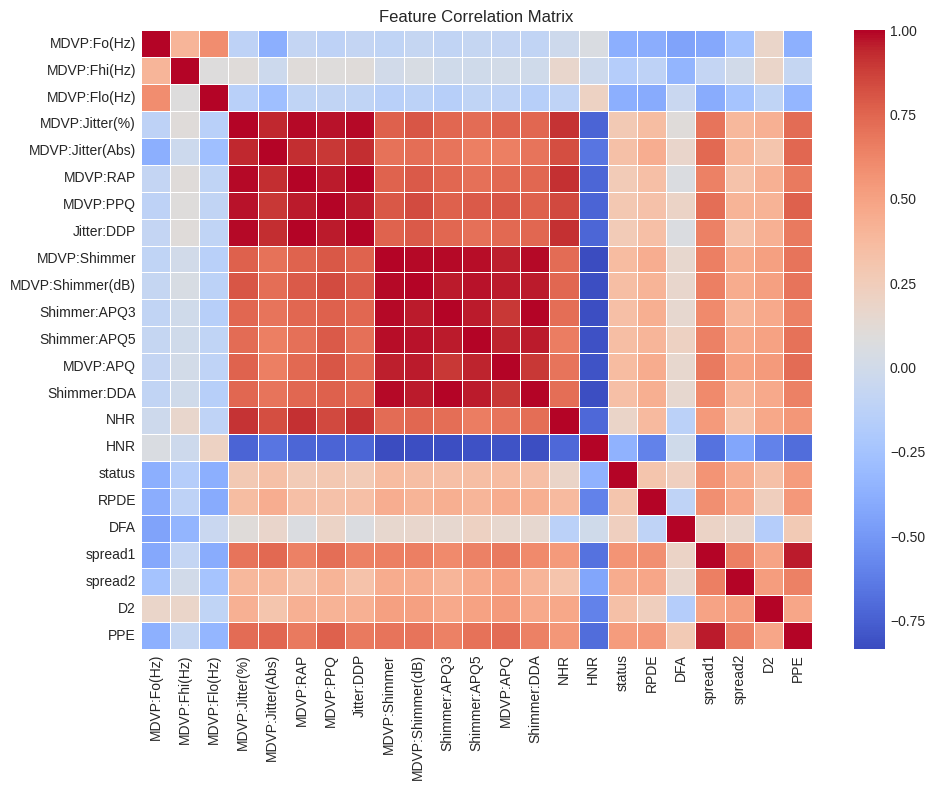

In [68]:

plt.figure(figsize=(10, 8))
sns.heatmap(df.drop(['name'], axis=1).corr(), cmap='coolwarm', linewidths=0.5, fmt=".1f")
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()


##EDA: Violin Plots (Distributions) & KDE Plots (Density)


*   Comparing the distribution of key voice features between Healthy patients (0) and Parkinson's patients (1). Violin plots show both the summary statistics and the density of the data.
*   Kernel Density Estimation (KDE) plots allow us to see the overlap between the two classes. Less overlap implies a feature is a better predictor.



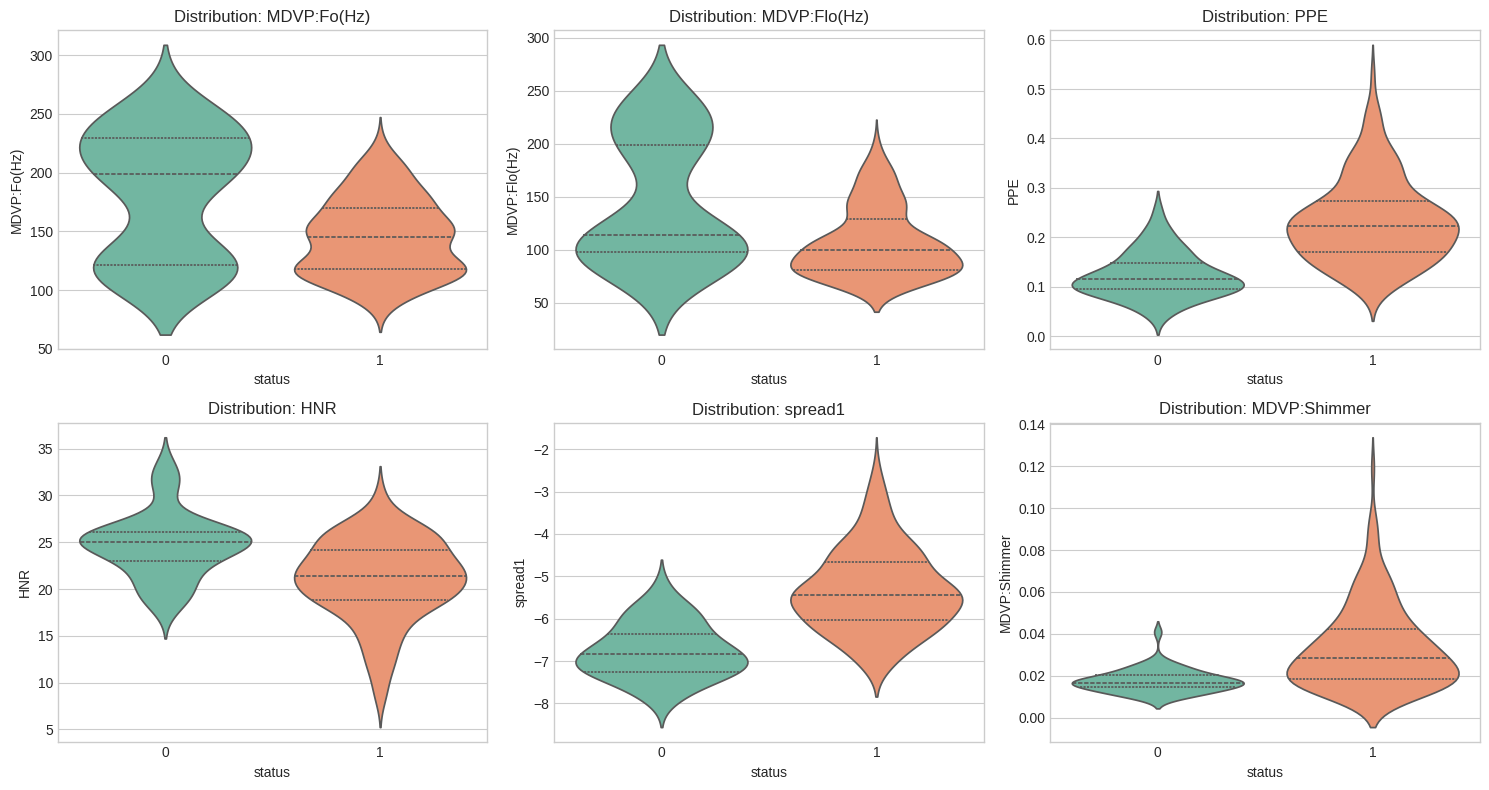

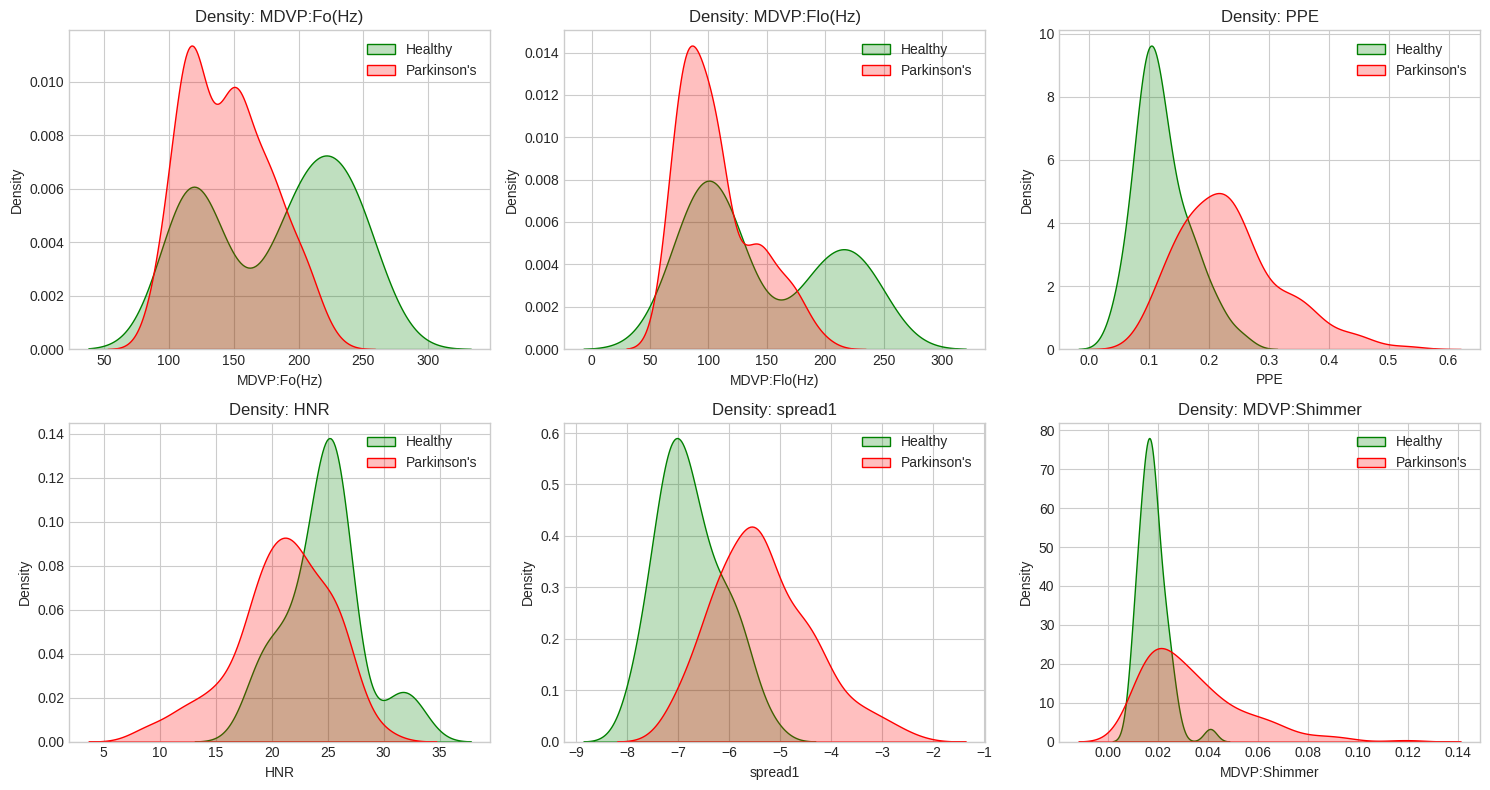

In [69]:

viz_features = ['MDVP:Fo(Hz)', 'MDVP:Flo(Hz)', 'PPE', 'HNR', 'spread1', 'MDVP:Shimmer']
plt.figure(figsize=(15, 8))
for i, col in enumerate(viz_features):
    if col in df.columns:
        plt.subplot(2, 3, i+1)
        sns.violinplot(x='status', y=col, data=df, palette='Set2', inner="quartile")
        plt.title(f'Distribution: {col}')
plt.tight_layout()
plt.show()
plt.figure(figsize=(15, 8))
for i, col in enumerate(viz_features):
    if col in df.columns:
        plt.subplot(2, 3, i+1)
        sns.kdeplot(df[df['status']==0][col], fill=True, color='green', label='Healthy')
        sns.kdeplot(df[df['status']==1][col], fill=True, color='red', label='Parkinson\'s')
        plt.title(f'Density: {col}')
        plt.legend()
plt.tight_layout()
plt.show()



# ***Preprocessing and Splitting***


1. Removing non-feature columns (`name`).
2. Splitting data into 80% Training and 20% Testing sets (Stratified to maintain class balance).
3. Standard Scaling features to mean=0 and variance=1 (crucial for SVM and Neural Networks).

**Standard Scaling Formula:**
To ensure features like "Jitter" and "Shimmer" are on the same scale, we transform each feature $x$:

$$
x_{scaled} = \frac{x - \mu}{\sigma}
$$
Where $\mu$ is the mean of the feature and $\sigma$ is the standard deviation.

In [70]:
X = df.drop(['name', 'status'], axis=1)
y = df['status']
feature_names = X.columns
# Split: 80% Train, 20% Test (Stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Data split and scaled.")


Data split and scaled.


# ***Model Training***

## Gradient Boosting
Training a Gradient Boosting Classifier and optimizing it using GridSearchCV. This model builds trees sequentially to correct the errors of previous trees.

**Additive Model:**
Gradient Boosting builds an ensemble of weak learners (trees) sequentially.

The prediction at step $m$ is:

$$
F_m(x) = F_{m-1}(x) + \eta \cdot h_m(x)
$$

Where $h_m(x)$ is the new decision tree trained on the pseudo-residuals, and $\eta$ is the learning rate.


In [71]:
gb_clf = GradientBoostingClassifier(random_state=42)
gb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 4],
    'subsample': [0.8, 1.0]
}
gb_search = GridSearchCV(gb_clf, gb_params, cv=5, n_jobs=-1, scoring='accuracy')
gb_search.fit(X_train_scaled, y_train)
best_gb = gb_search.best_estimator_
print(f"Best GB Params: {gb_search.best_params_}")


Best GB Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


## Support Vector Machine (SVM)
Training an SVM with an RBF kernel. We use `class_weight='balanced'` to handle the imbalance in the dataset.

**Radial Basis Function (RBF) Kernel:**
Since the data is not linearly separable, we use the RBF kernel to map the input space to a higher dimension:

$$
K(x_i, x_j) = \exp\left(-\gamma ||x_i - x_j||^2\right)
$$
Where $||x_i - x_j||^2$ is the squared Euclidean distance between two data points.

### Visualising Non Linearity ( PCA & t-SNE )
Before training the SVM, we verify if the data is linearly separable. We use Principal Component Analysis (PCA) to project the data into 2D space.

**PCA Interpretation:**
If the "Healthy" and "Parkinson's" clusters overlap significantly and cannot be separated by a straight line, it justifies using a **non-linear kernel** (like RBF) for our Support Vector Machine.

**t-SNE Interpretation:**
t-SNE preserves local structure. If "Healthy" and "Parkinson's" points are mixed in the t-SNE plot, the classification task is non-trivial and requires non-linear models.

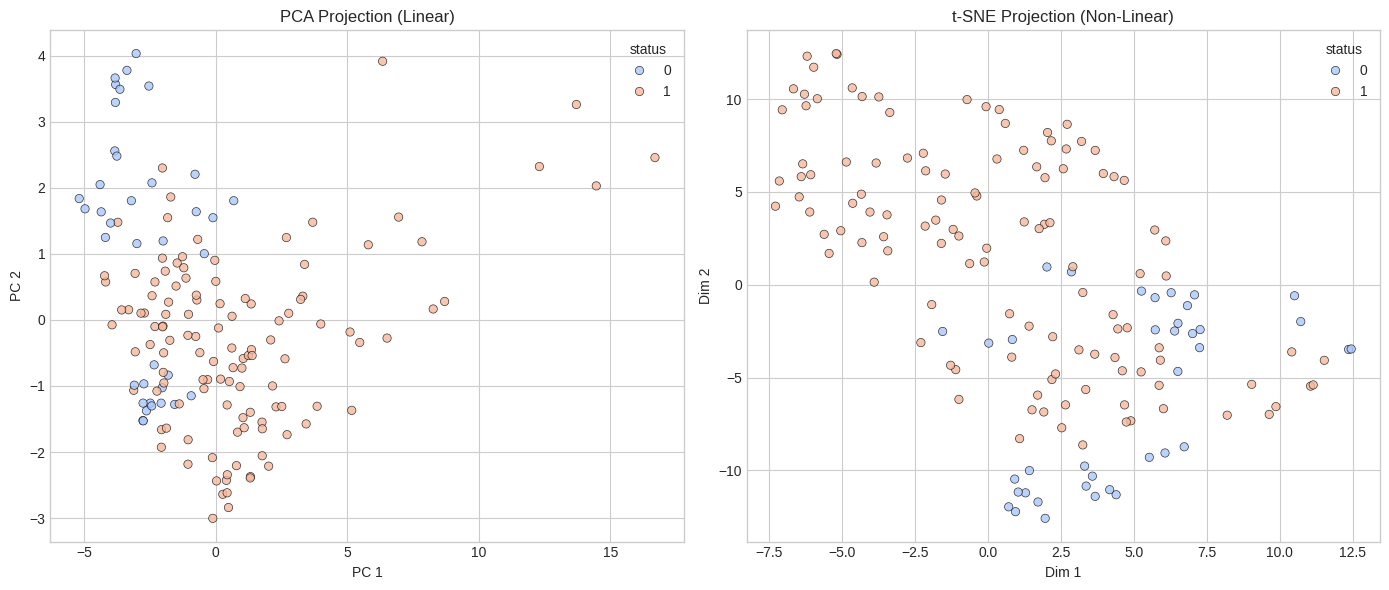

In [72]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

# t-SNE is probabilistic and often finds clusters PCA misses
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_train_scaled)

plt.figure(figsize=(14, 6))

# PCA Plot
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_train, palette='coolwarm', alpha=0.8, edgecolor='k')
plt.title('PCA Projection (Linear)')
plt.xlabel('PC 1')
plt.ylabel('PC 2')

# t-SNE Plot
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_train, palette='coolwarm', alpha=0.8, edgecolor='k')
plt.title('t-SNE Projection (Non-Linear)')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')

plt.tight_layout()
plt.show()


### Training the model

In [73]:
svm_clf = SVC(probability=True, random_state=42, kernel='rbf', class_weight='balanced')
svm_params = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto', 0.1]}
svm_search = GridSearchCV(svm_clf, svm_params, cv=5, n_jobs=-1, scoring='accuracy')
svm_search.fit(X_train_scaled, y_train)
best_svm = svm_search.best_estimator_
print(f"Best SVM Params: {svm_search.best_params_}")

Best SVM Params: {'C': 10, 'gamma': 0.1}


## Neural Network (MLP)

Building a Dense Neural Network using TensorFlow/Keras.
* **Dropout layers** are used to prevent overfitting on this small dataset.

* **Early Stopping** is implemented to halt training when validation loss stops improving.

**Neuron Activation (Sigmoid):**
In the final output layer, we use the Sigmoid activation function to output a probability between 0 and 1:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

**Binary Cross-Entropy Loss:**
The network learns by minimizing the difference between the predicted probability ($\hat{y}$) and the actual label ($y$):

$$
L = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]
$$

In [74]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=0
)
print("Neural Network Training Complete.")


Neural Network Training Complete.


# ***Final Voting and Ensemble***


We create a **Soft Voting Ensemble** by averaging the probability predictions of all three models. This often yields better generalization than any single model.


**Soft Voting:**
The final prediction is the average of the probabilities predicted by the Gradient Boosting ($P_{GB}$), SVM ($P_{SVM}$), and Neural Network ($P_{NN}$) models:

$$
P_{final}(y=1|x) = \frac{P_{GB}(y=1|x) + P_{SVM}(y=1|x) + P_{NN}(y=1|x)}{3}
$$

**Classification Rule:**
$$
\hat{y} = \begin{cases}
1 & \text{if } P_{final} > 0.5 \\
0 & \text{otherwise}\end{cases}
$$


In [75]:
# Predictions
gb_probs = best_gb.predict_proba(X_test_scaled)[:, 1]
svm_probs = best_svm.predict_proba(X_test_scaled)[:, 1]
nn_probs = model.predict(X_test_scaled).flatten()

# Ensemble (Soft Voting)
ensemble_probs = (gb_probs + svm_probs + nn_probs) / 3
ensemble_preds = (ensemble_probs > 0.5).astype(int)

print("\n" + "="*50)
print("Ensemble Performance Report")
print("="*50)
print(classification_report(y_test, ensemble_preds, target_names=['Healthy', 'Parkinson\'s']))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step

Ensemble Performance Report
              precision    recall  f1-score   support

     Healthy       0.90      0.90      0.90        10
 Parkinson's       0.97      0.97      0.97        29

    accuracy                           0.95        39
   macro avg       0.93      0.93      0.93        39
weighted avg       0.95      0.95      0.95        39



# ***Final Charts***

## Confusion Matrix


1.   Gradient Boosting
2.   Support Vector Machine
3.   Neural Network(MLP)
4.   Ensemble


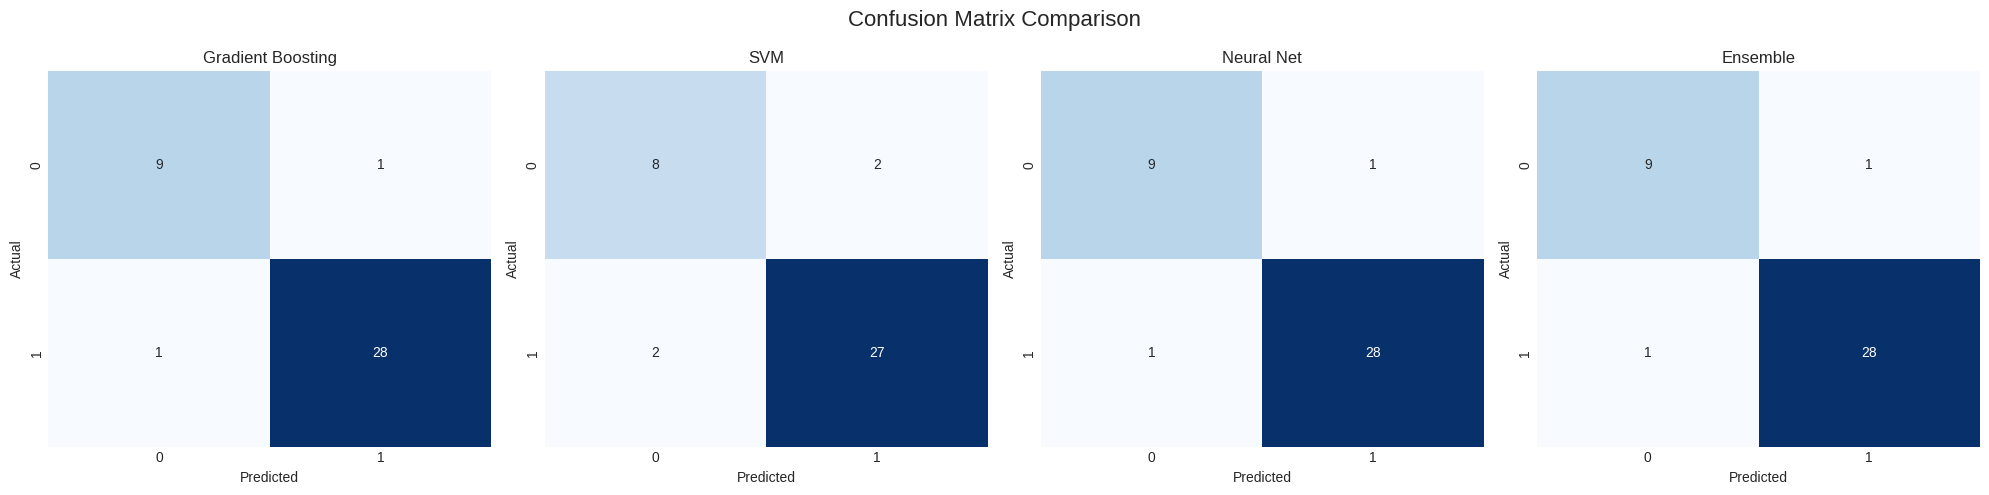

In [76]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
models_data = [
    ('Gradient Boosting', (gb_probs > 0.5).astype(int)),
    ('SVM', (svm_probs > 0.5).astype(int)),
    ('Neural Net', (nn_probs > 0.5).astype(int)),
    ('Ensemble', ensemble_preds)
]
for ax, (name, preds) in zip(axes, models_data):
    sns.heatmap(confusion_matrix(y_test, preds), annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(name)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
plt.suptitle("Confusion Matrix Comparison", fontsize=16)
plt.tight_layout()
plt.show()


##  ROC Curves
The ROC Curve shows the trade-off between sensitivity and specificity. The AUC (Area Under Curve) score represents the overall ability of the model to discriminate between classes (1.0 is perfect).

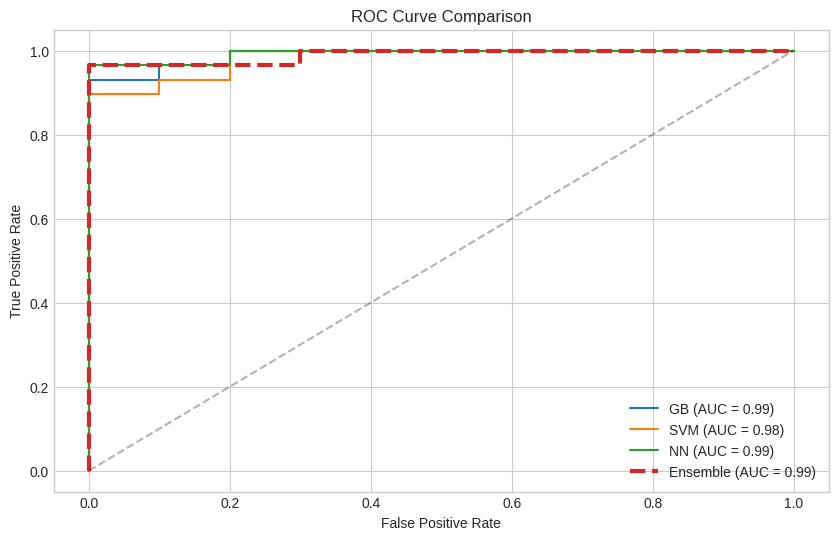

In [77]:
plt.figure(figsize=(10, 6))
for name, probs in [('GB', gb_probs), ('SVM', svm_probs), ('NN', nn_probs), ('Ensemble', ensemble_probs)]:
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc(fpr, tpr):.2f})',
             linestyle='--' if name == 'Ensemble' else '-',
             linewidth=3 if name == 'Ensemble' else 1.5)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.3)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()


## Feature Importance
Identifying which acoustic features were most influential in the Gradient Boosting model's decision-making process.

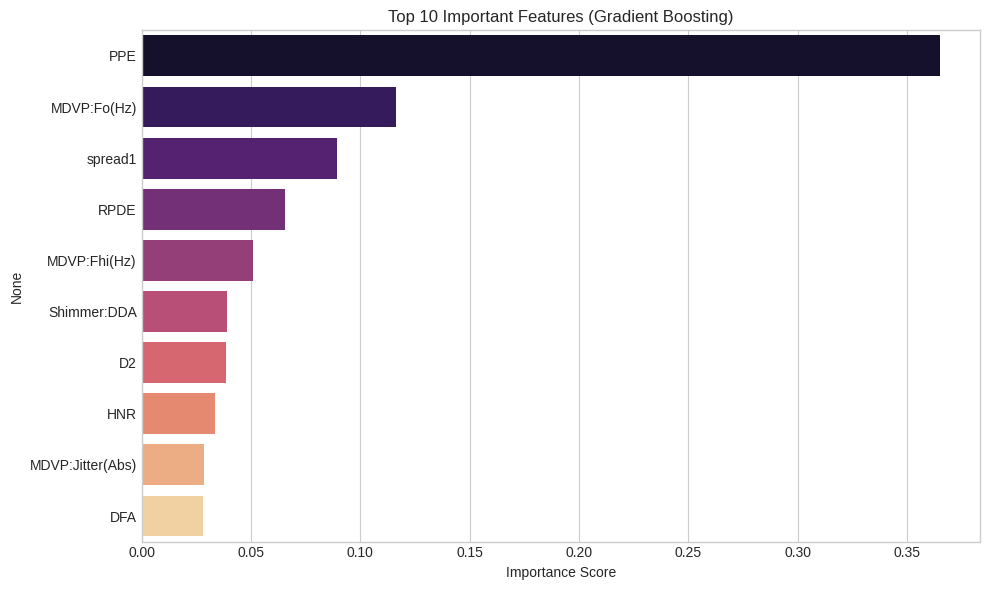

In [78]:
feat_imp = pd.Series(best_gb.feature_importances_, index=feature_names).sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='magma')
plt.title("Top 10 Important Features (Gradient Boosting)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

## Neural Network Training History
Plotting the loss and accuracy over epochs to check for overfitting. If Validation Loss increases while Train Loss decreases, the model is overfitting.

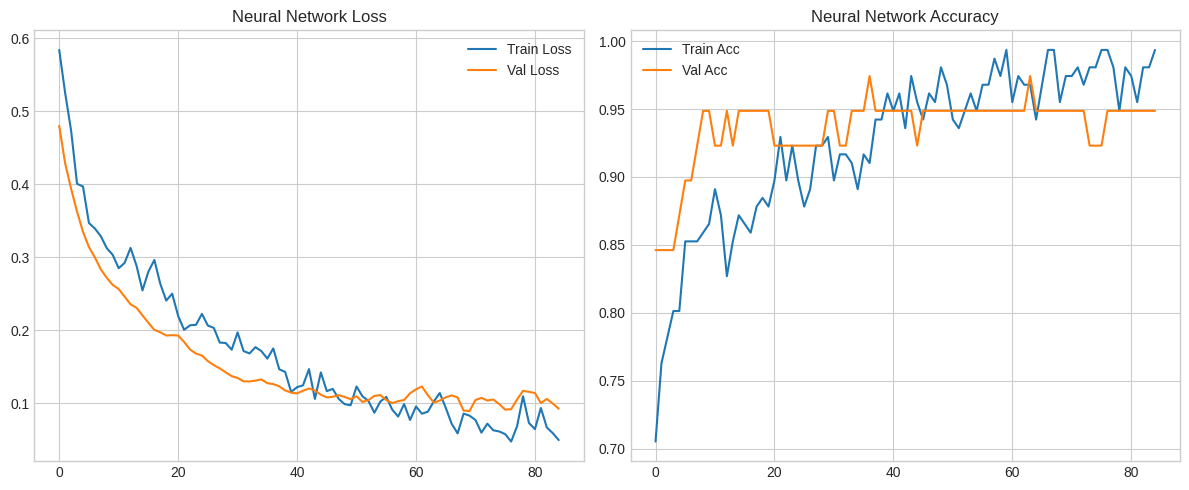

In [79]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Neural Network Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Neural Network Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


 ## Precision-Recall & Calibration Curves
**Precision-Recall Curve:**
Useful for imbalanced datasets. It focuses on the performance of the positive class (Parkinson's).

**Calibration Curve:**
Checks if the predicted probabilities match the actual frequency of the positive class. Ideally, points should fall on the diagonal.


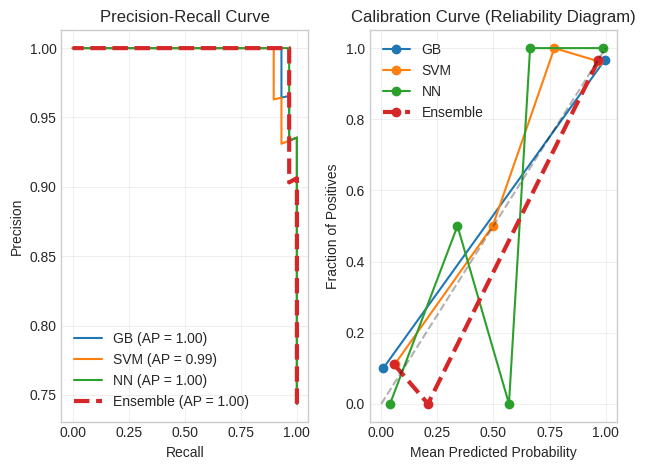

In [80]:
# Plot 1: Precision-Recall Curve
plt.subplot(1, 2, 1)
for name, probs in [('GB', gb_probs), ('SVM', svm_probs), ('NN', nn_probs), ('Ensemble', ensemble_probs)]:
    precision, recall, _ = precision_recall_curve(y_test, probs)
    avg_prec = average_precision_score(y_test, probs)
    plt.plot(recall, precision, label=f'{name} (AP = {avg_prec:.2f})',
             linestyle='--' if name == 'Ensemble' else '-',
             linewidth=3 if name == 'Ensemble' else 1.5)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Calibration Curve
plt.subplot(1, 2, 2)
for name, probs in [('GB', gb_probs), ('SVM', svm_probs), ('NN', nn_probs), ('Ensemble', ensemble_probs)]:
    prob_true, prob_pred = calibration_curve(y_test, probs, n_bins=5)
    plt.plot(prob_pred, prob_true, marker='o', label=name,
             linestyle='--' if name == 'Ensemble' else '-',
             linewidth=3 if name == 'Ensemble' else 1.5)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.3)
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve (Reliability Diagram)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ***Model Explanibility***



**SHAP (SHapley Additive exPlanations)** is the gold standard for interpreting machine learning models. It uses Game Theory to explain the output of the model.

**Summary Plot:** Shows which features are most important and how they impact the prediction (e.g., does high "PPE" increase or decrease the risk of Parkinson's?).

**Red Points:** High feature value.

**Blue Points:** Low feature value.

**Position on X-axis:** Impact on prediction (Right = Higher Risk, Left = Lower Risk).

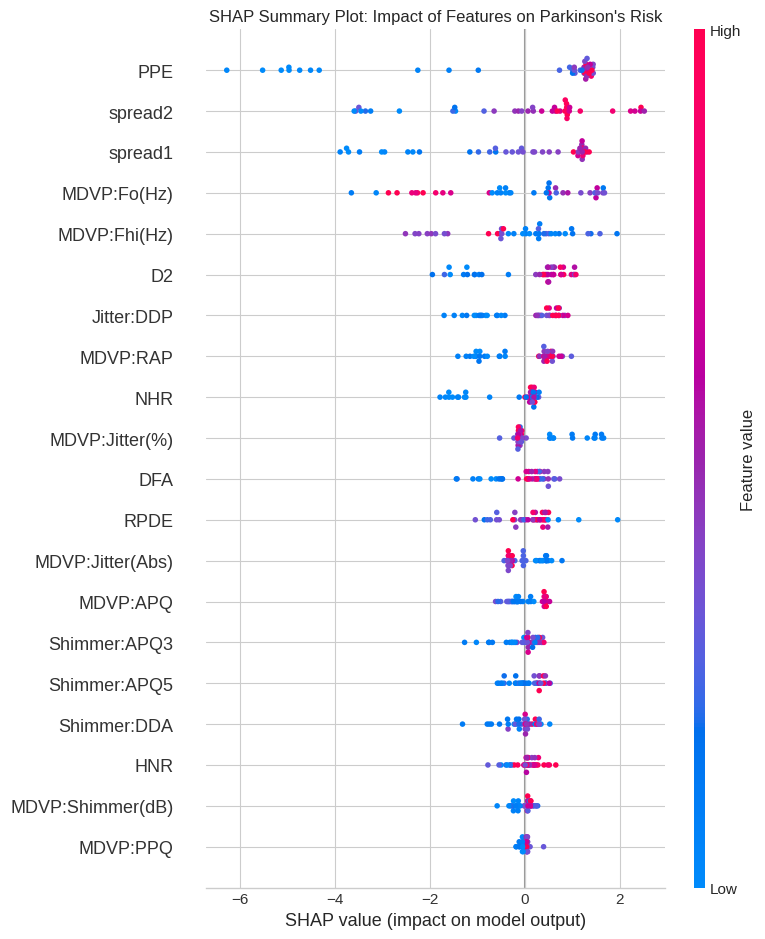

In [81]:
explainer = shap.TreeExplainer(best_gb)
shap_values = explainer.shap_values(X_test_scaled)

plt.figure(figsize=(10, 8))
plt.title("SHAP Summary Plot: Impact of Features on Parkinson's Risk")
# For binary classification, shap_values might be a list. We take index 1 (Positive class) if so.
if isinstance(shap_values, list):
    shap.summary_plot(shap_values[1], X_test_scaled, feature_names=feature_names, show=False)
else:
    shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_names, show=False)
plt.show()

# ***Conclusion and Deployment Simulation***

To make this analysis actionable, we simulate a real-world deployment scenario.
1. **Medical Metrics:** We calculate Sensitivity (Recall) and Specificity, which are critical for medical diagnostics.
2. **Prediction System:** A function that acts like a diagnostic tool for a doctor.


In [82]:
import joblib

print("\n" + "="*50)
print("FINAL MEDICAL METRICS")
print("="*50)

# Calculate Sensitivity and Specificity from Confusion Matrix
# TN = True Negative, FP = False Positive, FN = False Negative, TP = True Positive
tn, fp, fn, tp = confusion_matrix(y_test, ensemble_preds).ravel()

sensitivity = tp / (tp + fn) # Ability to find the sick
specificity = tn / (tn + fp) # Ability to recognize the healthy

print(f"Sensitivity (True Positive Rate): {sensitivity:.2%}")
print(f"Specificity (True Negative Rate): {specificity:.2%}")
print(f"Global Accuracy:                  {accuracy_score(y_test, ensemble_preds):.2%}")

# Save the models and scaler for real-world use
print("\nSaving models to disk...")
joblib.dump(best_gb, 'parkinsons_gb_model.pkl')
joblib.dump(best_svm, 'parkinsons_svm_model.pkl')
model.save('parkinsons_mlp_model.keras')
joblib.dump(scaler, 'parkinsons_scaler.pkl')
print("Models and Scaler saved successfully.")

def predict_patient_risk(patient_features):
    """
    Simulates a doctor inputting patient data.
    Input: Raw numerical features (unscaled)
    Output: Risk Score and Diagnosis
    """
    # 1. Scale the raw data using the saved scaler
    patient_scaled = scaler.transform(patient_features.reshape(1, -1))

    # 2. Get probabilities from all 3 models
    p_gb = best_gb.predict_proba(patient_scaled)[0][1]
    p_svm = best_svm.predict_proba(patient_scaled)[0][1]
    p_nn = model.predict(patient_scaled, verbose=0)[0][0]

    # 3. Soft Voting (Average Risk)
    avg_risk = (p_gb + p_svm + p_nn) / 3

    # 4. Generate Report
    print(f"\n--- DIAGNOSTIC REPORT ---")
    print(f"Gradient Boosting Risk: {p_gb:.1%}")
    print(f"SVM Risk:               {p_svm:.1%}")
    print(f"Neural Network Risk:    {p_nn:.1%}")
    print(f"-"*25)
    print(f"AGGREGATED RISK SCORE:  {avg_risk:.1%}")

    if avg_risk > 0.5:
        print(">> DIAGNOSIS: HIGH RISK of Parkinson's")
    else:
        print(">> DIAGNOSIS: LOW RISK (Healthy)")

# Test on a random patient from the test set to demonstrate
import random
random_idx = random.randint(0, len(X_test) - 1)
sample_patient = X_test.iloc[random_idx].values
actual_status = y_test.iloc[random_idx]

print(f"\n[Simulation] Selected Random Patient #{random_idx}")
print(f"Actual Clinical Status: {'Parkinsons' if actual_status == 1 else 'Healthy'}")
predict_patient_risk(sample_patient)

# Create models directory if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')
# Save to models/ folder
joblib.dump(best_gb, 'models/parkinsons_gb_model.pkl')
joblib.dump(best_svm, 'models/parkinsons_svm_model.pkl')
model.save('models/parkinsons_mlp_model.keras')
joblib.dump(scaler, 'models/parkinsons_scaler.pkl')


FINAL MEDICAL METRICS
Sensitivity (True Positive Rate): 96.55%
Specificity (True Negative Rate): 90.00%
Global Accuracy:                  94.87%

Saving models to disk...
Models and Scaler saved successfully.

[Simulation] Selected Random Patient #17
Actual Clinical Status: Parkinsons

--- DIAGNOSTIC REPORT ---
Gradient Boosting Risk: 100.0%
SVM Risk:               92.6%
Neural Network Risk:    100.0%
-------------------------
AGGREGATED RISK SCORE:  97.5%
>> DIAGNOSIS: HIGH RISK of Parkinson's


['models/parkinsons_scaler.pkl']